C:\Users\kmml910\AppData\Local\Temp\ipykernel_9296\1825926281.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Fragment_{i}_Presence'] = fragment_matrix[:, mlb.classes_ == frag].flatten()
C:\Users\kmml910\AppData\Local\Temp\ipykernel_9296\1825926281.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Fragment_{i}_Presence'] = fragment_matrix[:, mlb.classes_ == frag].flatten()
C:\Users\kmml910\AppData\Local\Temp\ipykernel_9296\1825926281.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

                                          Fragment  Chi-Square       p-value
0                 [16*]c1cc(=O)[nH]c2c(F)c(F)ccc12   35.720549  2.277490e-09
1                       [1*]C(=O)[C@@H]([4*])C[8*]   20.054138  7.528045e-06
2                                    [16*]c1ccncc1   20.218767  6.907199e-06
3                            [16*]c1c[nH]c2ccccc12   18.899481  1.377901e-05
4                                    [15*]C1CCCCC1   15.098869  1.020244e-04
5                              [14*]c1coc([14*])n1   18.556563  1.649363e-05
6    [1*]C(=O)C1=CN([5*])CC(C)(C)c2c1[nH]c1ccccc21    9.868982  1.680885e-03
7                                    [1*]C([6*])=O   15.080154  1.030409e-04
8                               [16*]c1ccccc1[16*]    8.766599  3.067969e-03
9                     [9*]n1c([14*])[nH+]c2ccccc21   13.272864  2.692755e-04
10                               [4*][C@H](C)CCCCC   13.366638  2.561401e-04
11                                       [7*]C[8*]    9.302150  2.288851e-03

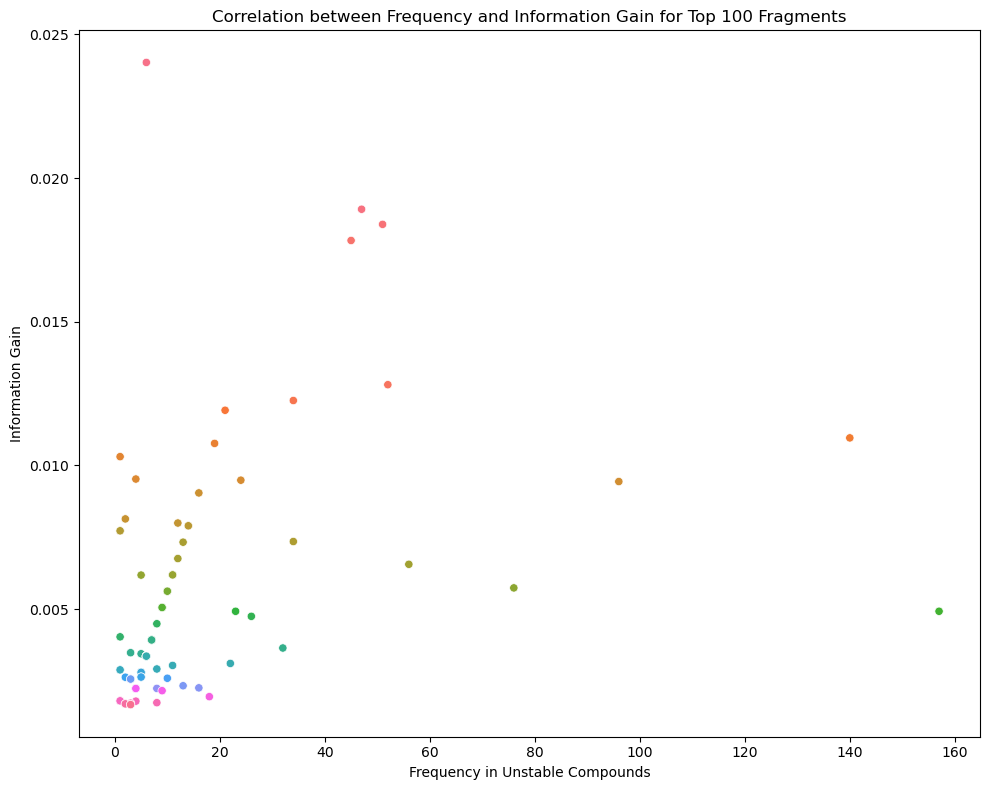

c:\Users\kmml910\AppData\Local\anaconda3\envs\mouse_microsomal_stability\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


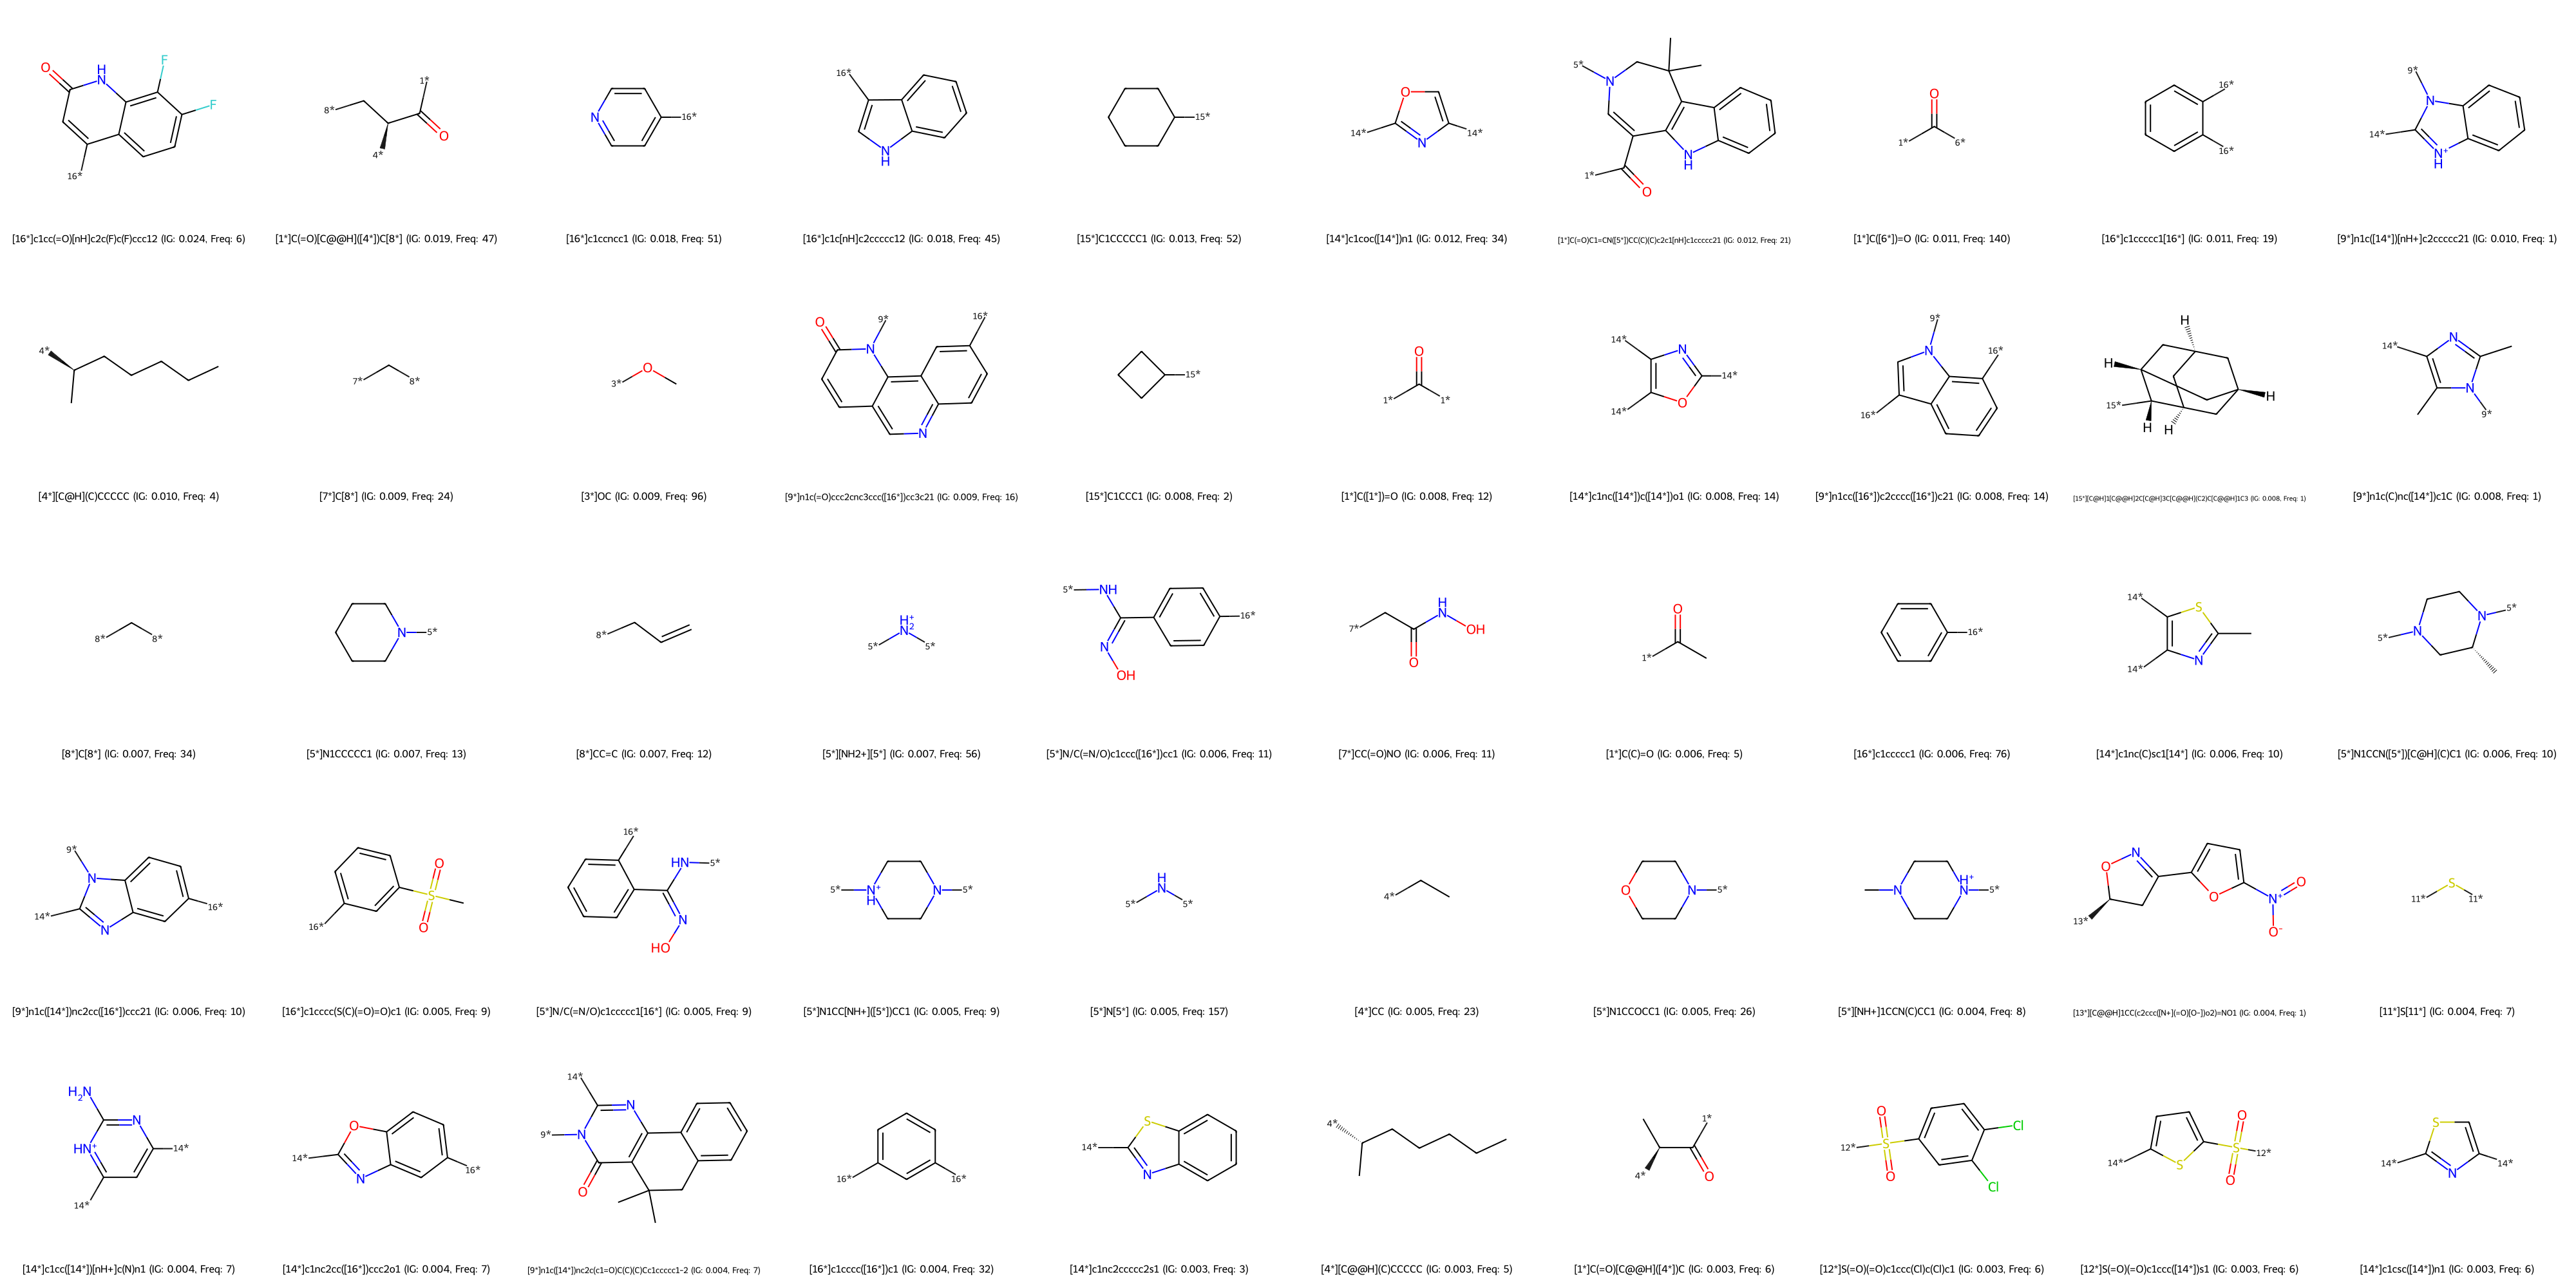

In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem.Draw import MolsToGridImage
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import chi2_contingency
from IPython.display import display
import seaborn as sns

# Path to your SDF file
sdf_file = "Structures_759_training.sdf"  

# Load the molecules from the SDF file
mols = [mol for mol in Chem.SDMolSupplier(sdf_file) if mol is not None]

# Create a DataFrame with SMILES and the 'Stable' labels
df = pd.DataFrame({
    'SMILES': [Chem.MolToSmiles(mol) for mol in mols],
    'Stable': [int(mol.GetProp('Stable')) for mol in mols]
})

# Function to generate fragments using BRICS decomposition
def generate_fragments(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return BRICS.BRICSDecompose(mol)
        else:
            return set()
    except:
        return set()

# Extract BRICS fragments for each SMILES
df['Fragments'] = df['SMILES'].apply(generate_fragments)

# Binarize the presence of fragments across molecules
mlb = MultiLabelBinarizer()
fragment_matrix = mlb.fit_transform(df['Fragments'])

# Calculate mutual information for features (fragments)
mi_scores = mutual_info_classif(fragment_matrix, df['Stable'], discrete_features=True)

# Calculate fragment frequency in unstable compounds
unstable_fragments = Counter()
for _, row in df.iterrows():
    if row['Stable'] == 0:
        unstable_fragments.update(row['Fragments'])

# Combine data for analysis
fragment_data = pd.DataFrame({
    'Fragment': mlb.classes_,
    'Frequency': [unstable_fragments.get(frag, 0) for frag in mlb.classes_],
    'Information Gain': mi_scores
})

# Filter for meaningful correlations, remove zero frequencies
fragment_data = fragment_data.loc[fragment_data['Frequency'] > 0]

# Review top fragments with non-zero frequencies
top_fragment_data = fragment_data.nlargest(100, 'Information Gain')

# Iterate over the top 100 fragments and perform Chi-Square tests
chi_square_results = []

for i, frag in enumerate(top_fragment_data['Fragment']):
    # Create presence column for the fragment
    df[f'Fragment_{i}_Presence'] = fragment_matrix[:, mlb.classes_ == frag].flatten()
    
    # Build contingency table
    contingency_table = pd.crosstab(df['Stable'], df[f'Fragment_{i}_Presence'])
    
    # Perform Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    chi_square_results.append({'Fragment': frag, 'Chi-Square': chi2, 'p-value': p})

# Convert results to DataFrame
chi_square_df = pd.DataFrame(chi_square_results)

# Display fragments with significant differences
significant_fragments = chi_square_df[chi_square_df['p-value'] < 0.05]
print(significant_fragments)

# Plot visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(data=top_fragment_data, x='Frequency', y='Information Gain', hue='Fragment', legend=False)
plt.title('Correlation between Frequency and Information Gain for Top 100 Fragments')
plt.xlabel('Frequency in Unstable Compounds')
plt.ylabel('Information Gain')
plt.tight_layout()
plt.show()

# Draw top substructures
substruct_mols = [Chem.MolFromSmiles(frag) for frag in top_fragment_data['Fragment'] if frag]
substruct_labels = [f"{frag} (IG: {ig:.3f}, Freq: {freq})" for frag, ig, freq in zip(top_fragment_data['Fragment'], top_fragment_data['Information Gain'], top_fragment_data['Frequency'])]

# Display molecules
img = MolsToGridImage(substruct_mols, legends=substruct_labels, molsPerRow=10, subImgSize=(400, 400))
display(img)